In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

def create_model(nodes1,nodes2,hidden_layers,activ,optim):
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.GRU(nodes1, input_shape=(3000,1,))))
    for x in range(hidden_layers-1):
        model.add(keras.layers.Dense(nodes2,activation=activ))
    model.add(keras.layers.Dense(1009,activation='softmax'))
    return model

def create_model_dropout(nodes1,nodes2,hidden_layers,activ,optim,drop_rate):
    model = keras.models.Sequential()
    model.add(keras.layers.Dropout(drop_rate,input_shape=(3000,1)))
    model.add(keras.layers.Bidirectional(keras.layers.GRU(nodes1)))
    for x in range(hidden_layers-1):
        model.add(keras.layers.Dropout(drop_rate))
        model.add(keras.layers.Dense(nodes2,activation=activ))
    model.add(keras.layers.Dense(1009,activation='softmax'))
    return model

In [2]:
class model_object:
    def __init__(self,short_name):
        self.short_name = short_name
        self.full_name = 'saved_models/'+short_name
        self.attri = []
        for x in short_name.split(','):
            try:
                x = int(x)
            except:
                pass
            self.attri.append(x)
            
        if 'dropout' in self.attri:
            self.model = create_model_dropout(self.attri[0],self.attri[1],self.attri[2],self.attri[3],self.attri[4],.2)
        else: 
            self.model = create_model(self.attri[0],self.attri[1],self.attri[2],self.attri[3],self.attri[4])
            
            
    def get_stats(self,x,y):
        self.model(np.zeros((1,3000,1)))
        self.model.load_weights(self.full_name)
        self.model.compile(loss='categorical_crossentropy',optimizer=self.attri[4],metrics=['accuracy'])
        
        print('Evaluating: ', self.short_name)
        results = self.model.evaluate(x,y)
        self.loss = results[0]
        self.acc = results[1]
        clear_output(wait=True)

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
from tensorflow import keras

start=datetime.now()
temp = pd.read_csv('Data/cv-valid-train.csv')
texts = temp['text']

words_list = np.hstack([x.split(' ') for x in texts])
words_list_df = pd.Series(words_list)
temp = words_list_df.value_counts()

common_words = temp[:1000]
for ind in range(1000,len(temp)):
    num_freq = common_words[-1]
    if temp[ind] == num_freq:
        common_words = pd.concat([common_words,temp[ind:ind+1]])
    else: break
print(common_words)

temp = None
texts = None
words_list = None


df = pd.read_csv('Data/Samples_1.csv')
df['words'] = df['words'].where(df['words'].isin(common_words.index),'[UNRECOGNIZED]')
temp = df.loc[df['words']=='[UNRECOGNIZED]']
df_1 = df.loc[df['words']!='[UNRECOGNIZED]']
df_2 = temp.sample(frac=0.005)
df = pd.concat([df_1,df_2])
print(len(df))
end = datetime.now()
print(end-start)
df.head()

the             141274
to               55997
and              41557
a                40516
of               36293
                 ...  
carried            230
medaling           230
rushing            230
specifically       230
junior             230
Length: 1009, dtype: int64
40900
0:00:43.625287


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_2991,sample_2992,sample_2993,sample_2994,sample_2995,sample_2996,sample_2997,sample_2998,sample_2999,words
0,129,206,227,208,275,402,474,559,658,880,...,-6458,-4407,-2736,-1968,0,0,0,0,0,learn
1,-4786,-3695,-694,2025,3114,2906,1890,1563,2868,4372,...,6378,-4740,-14274,-14041,0,0,0,0,0,to
3,718,165,-1624,-1544,1007,620,1096,-1256,-1975,60,...,345,1353,1125,-5120,-5043,-3150,-4747,-5659,-5833,omens
4,320,-109,590,895,389,334,871,948,1581,1838,...,-20211,-20799,-21697,-18167,0,0,0,0,0,and
6,508,-265,-1375,-2541,-3028,-2754,-2325,-2041,-2351,-2699,...,41,-133,-379,-513,0,0,0,0,0,them


In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

start = datetime.now()
X = df.drop('words',axis=1)
y_raw = df['words']

words_list = pd.Series(y_raw).value_counts()

lb = LabelBinarizer()
lb.fit(words_list.index)
y = lb.transform(y_raw)
print(y.shape)


#X_train,X_val,y_train,y_val = train_test_split(X,y)
ss = StandardScaler()
X_scale = ss.fit_transform(X)
X_final = X_scale.reshape(X.shape[0],3000,1)
print('X preprocessed')


num_unrec = round((len(words_list_df)-sum(common_words))*.005)
temp = pd.Series(num_unrec)
temp.index = ['[UNRECOGNIZED]']
words_list = pd.concat([common_words,temp])


class_weight_dict = {}
for ind in range(len(words_list)):
    word = words_list.index[ind]
    word_ind = lb.transform([word]).argmax()
    class_weight_dict[word_ind] = sum(words_list)/(len(words_list)*words_list[ind])
weight_dict_sorted = dict(sorted(class_weight_dict.items()))
        
end = datetime.now()
print(end-start)

(40900, 1009)
X preprocessed
0:00:32.193483


Generally, try to compare 2nd epoch, as that is the most common for most optimizers <br>
Comparisons: 1-3, 1&4, 4-6, 6-8, 8-11

1. 64,64,2,relu,Adagrad,2
2. 64,64,2,LeakyReLU,Adagrad,2
3. 64,64,2,tanh,Adagrad,2
4. 64,64,2,relu,Nadam,2
5. 64,64,2,relu,Nadam,1,50
6. 100,100,2,relu,Nadam,3,25
7. 100,100,2,relu,Nadam,3,25,dropout
8. 100,100,2,relu,Nadam,4,25,moreData
9. 100,100,2,relu,Ftrl,2,25
10. 100,100,2,relu,RMSprop,2,25
11. 100,100,2,relu,SGD,2,25

In [5]:
start = datetime.now()

file_1 = model_object('64,64,2,relu,Adagrad,2')
file_1.get_stats(X_final,y)
activ_2 = model_object('64,64,2,LeakyReLU,Adagrad,2')
activ_2.get_stats(X_final,y)
activ_3 = model_object('64,64,2,tanh,Adagrad,2')
activ_3.get_stats(X_final,y)

Nadam_1 = model_object('64,64,2,relu,Nadam,2')
Nadam_1.get_stats(X_final,y)
small_batch = model_object('64,64,2,relu,Nadam,1,50')
small_batch.get_stats(X_final,y)
smaller_batch = model_object('100,100,2,relu,Nadam,3,25')
smaller_batch.get_stats(X_final,y)
dropout = model_object('100,100,2,relu,Nadam,3,25,dropout')
dropout.get_stats(X_final,y)

optim_1 = model_object('100,100,2,relu,Nadam,4,25,moreData')
optim_1.get_stats(X_final,y)
optim_2 = model_object('100,100,2,relu,Ftrl,2,25')
optim_2.get_stats(X_final,y)
optim_3 = model_object('100,100,2,relu,RMSprop,2,25')
optim_3.get_stats(X_final,y)
optim_4 = model_object('100,100,2,relu,SGD,2,25')
optim_4.get_stats(X_final,y)

end = datetime.now()
print(end-start)

ValueError: Cannot assign to variable bidirectional_6/forward_gru_6/gru_cell_19/kernel:0 due to variable shape (1, 300) and value shape (1, 450) are incompatible

Text(0.5, 1.0, 'Accuracy')

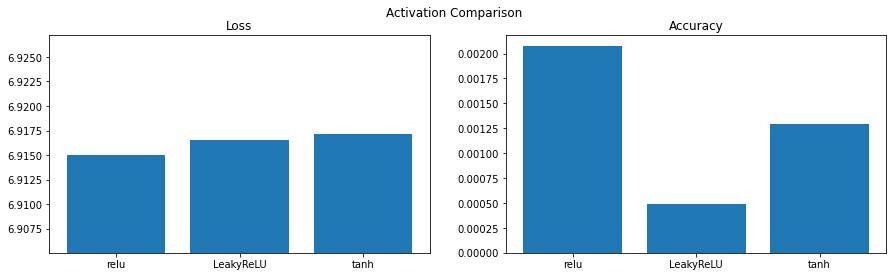

In [12]:
activ_set = [file_1,activ_2,activ_3]
optim_set_1 = [file_1,Nadam_1]
batch_size_set = [Nadam_1,small_batch,smaller_batch]

x = [file.attri[3] for file in activ_set]
y_l = [file.loss for file in activ_set]
y_a = [file.acc for file in activ_set]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle('Activation Comparison')
ax1.bar(x, y_l)
ax1.set_title('Loss')
ax1.set_ylim(bottom=min(y_l)-.01,top=max(y_l)+.01)
ax2.bar(x, y_a)
ax2.set_title('Accuracy')

Text(0.5, 1.0, 'Accuracy')

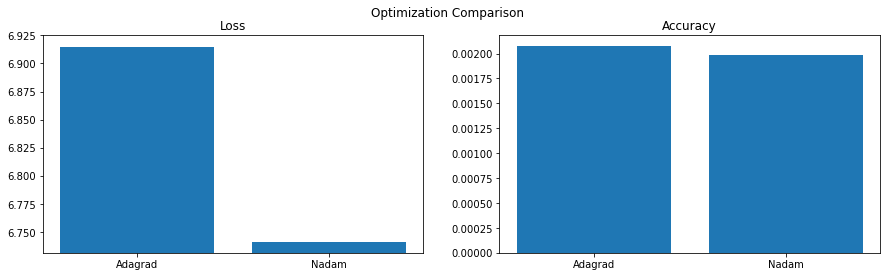

In [13]:
x = [file.attri[4] for file in optim_set_1]
y_l = [file.loss for file in optim_set_1]
y_a = [file.acc for file in optim_set_1]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle('Optimization Comparison')
ax1.bar(x, y_l)
ax1.set_title('Loss')
ax1.set_ylim(bottom=min(y_l)-.01,top=max(y_l)+.01)
ax2.bar(x, y_a)
ax2.set_title('Accuracy')

Text(0.5, 1.0, 'Accuracy')

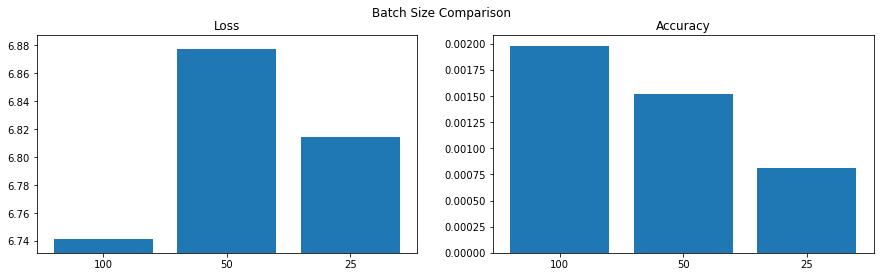

In [15]:
x = ['100','50','25']
y_l = [file.loss for file in batch_size_set]
y_a = [file.acc for file in batch_size_set]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle('Batch Size Comparison')
ax1.bar(x, y_l)
ax1.set_title('Loss')
ax1.set_ylim(bottom=min(y_l)-.01,top=max(y_l)+.01)
ax2.bar(x, y_a)
ax2.set_title('Accuracy')

In [4]:
from IPython.display import clear_output
loss_relu = []
acc_relu = []

base_name = 'saved_models/64,64,2,relu,Adagrad,'
model = create_model(64,64,2,'relu','Adagrad')

for x in range(2,11):
    file_name = base_name+str(x)
    model(np.zeros((1,3000,1)))
    model.load_weights(file_name)
    model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])
    
    print('Evaluating epoch',x)
    results_train = model.evaluate(X_final,y)
    loss_relu.append(results_train[0])
    acc_relu.append(results_train[1])
    clear_output(wait=True)
    
    
loss_tanh = []
acc_tanh = []

base_name = 'saved_models/64,64,2,tanh,Adagrad,'
model = create_model(64,64,2,'tanh','Adagrad')

for x in range(1,5):
    file_name = base_name+str(x)
    model(np.zeros((1,3000,1)))
    model.load_weights(file_name)
    model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])
    
    print('Evaluating epoch',x)
    results_train = model.evaluate(X_final,y)
    loss_tanh.append(results_train[0])
    acc_tanh.append(results_train[1])
    clear_output(wait=True)

Evaluating epoch 4
1279/1279 [==============================] - 277s 215ms/step - loss: 6.9171 - accuracy: 0.0011


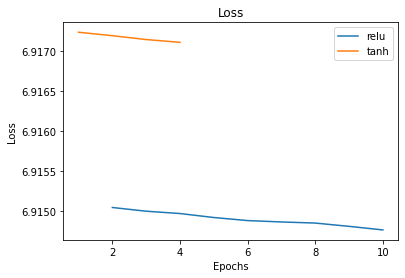

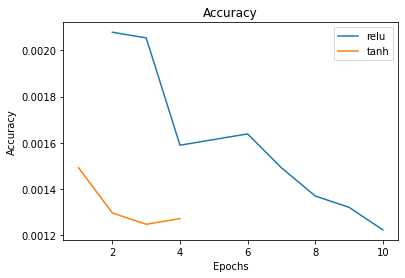

In [5]:
plt.figure()
plt.plot(range(2,11),loss_relu)
plt.plot(range(1,5),loss_tanh)
plt.legend(['relu', 'tanh'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(range(2,11),acc_relu)
plt.plot(range(1,5),acc_tanh)
plt.legend(['relu', 'tanh'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()